Online E-commerce websites like Amazon, Flipkart uses  different recommendation models to provide different  suggestions 
to different users. Amazon currently uses  item-to-item collaborative filtering, which scales to massive  data sets and 
produces high-quality recommendations in  real-time.  
Attribute Information: 
    ● userId : Every user identified with a unique id 
    ● productId : Every product identified with a unique id  
    ● Rating : Rating of the corresponding product by  the corresponding user   
    ● timestamp : Time of the rating ( ignore this column  for this exercise)  
        
Objective:  
Build a recommendation system to recommend products to  customers based on the their  previous ratings for other  products.  

Question 1. Read and explore the given dataset.  (Rename  column/add headers, plot histograms, find data  characteristics) 

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
#Read the file and rename the columns
# As we see the column names are not correct. Hence changing the column names together while loading the file to prevent loss
#of the first column
df = pd.read_csv('ratings_Electronics.csv', names=['userId', 'productId','Rating','timestamp'])
df.head()#printing the first 5 entries

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
print('the shape of the data is rows:',df.shape[0],'and columns are:',df.shape[1])
# checking the number of rows and columns in the data
df.shape

the shape of the data is rows: 7824482 and columns are: 4


(7824482, 4)

In [4]:
# As in the question there is no use of timestamp in the analysis, hence droping the column 'time stamp'.
df=df.drop(columns='timestamp',axis=1)

In [5]:
df.head()# checking the drop in column timestamp

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [6]:
# checking the datatypes of all the columns and also the null values
df.info()
#we see that userId and productId columns are object type while Ratings is Float type. 
#Also the number of columns are 3
#all columns have 7824482 entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
Rating       float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [8]:
print('Rating can be only from 1.0 to 5.0')
print('Half the ratings given are "5"! Majority of customers seem happy with the products.')

Rating can be only from 1.0 to 5.0
Half the ratings given are "5"! Majority of customers seem happy with the products.


In [9]:
print('all the columns have equal number of entries and no null values hence there is no missing value\n',df.isnull().sum())

all the columns have equal number of entries and no null values hence there is no missing value
 userId       0
productId    0
Rating       0
dtype: int64


In [10]:
#count of ratings per product
#Looking up the products
temp=df['productId'].value_counts().sort_values(ascending=False)
print('There are ',len(temp), 'unique products')
print('The least number of ratings any product (eg.', temp.index[-1],') got is ',temp[-1])
print('Product with productId=', temp.index[1], ' has got maximum number of ratings = ', temp.iloc[0])
print('productId and no. of times it has been rated:\n',temp)

There are  476002 unique products
The least number of ratings any product (eg. B0050Z4FTC ) got is  1
Product with productId= B00DR0PDNE  has got maximum number of ratings =  18244
productId and no. of times it has been rated:
 B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B003JCO1ME        1
B002JCSG0I        1
B00B2QC68U        1
B006OU946Q        1
B0050Z4FTC        1
Name: productId, Length: 476002, dtype: int64


In [11]:
#Looking up the users
temp=df['userId'].value_counts().sort_values(ascending=False)
print('There are ',len(temp), 'unique users')
print('The least number of ratings any user (eg.', temp.index[-1],') gave is ',temp[-1])
print('Product with userId=', temp.index[1], ' gave maximum number of ratings = ', temp.iloc[0])
print('userId and no. of products the user rated:\n',temp)

There are  4201696 unique users
The least number of ratings any user (eg. A32DTDSAWL47O3 ) gave is  1
Product with userId= ADLVFFE4VBT8  gave maximum number of ratings =  520
userId and no. of products the user rated:
 A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A8B9Y9G8DPUL0       1
AR8G4AT6AK4EP       1
AP9QM5KD52LLQ       1
A3TLK5VO6CQQ5       1
A32DTDSAWL47O3      1
Name: userId, Length: 4201696, dtype: int64


Question 2. Take a subset of the dataset to make it less sparse/ denser.  
( For example, keep the users only who has given 50 or  more number of ratings ) 

In [12]:
#Selecting the Users who have given more than 50 ratings and Products which have more than 50 ratings:

print('Since the objective is to put out a recommendation of some products to a user (so he would buy)')
print('Only those products that are popular (rated by many users) and users who have rated many products')
print('are expected to influence the products recommended')
print('REcommendations by the Collaborative method draw from ratings given by other users "similar" to the recommendee')
print('If very few users have recommended a product, their small numbers may not be sufficient to yield a')
print('statistically significant profiling for comparison with the recommendee profile')
print('Hence, we will consider only those products which have received at least fifty ratings and')
print('those users who have rated at least fifty products')
#Selecting the Users who have given more than 50 ratings and products rated by atleast 50 users
print('original dataset had ',df.shape[0], 'rating rows')
temp=df['userId'].value_counts()
new_data=df[df['userId'].isin(temp.index.where(temp>=50))]
temp=df['productId'].value_counts()
new_data=new_data[new_data['productId'].isin(temp.index.where(temp>=50))]
print('taking only users who rated more than 50 products and products rated by at least 50 users,')
print('dataset has ',new_data.shape[0], 'rating rows,')
print('comprising of ',len(new_data['userId'].unique()), 'unique users and',
      len(new_data['productId'].unique()), 'unique products')


Since the objective is to put out a recommendation of some products to a user (so he would buy)
Only those products that are popular (rated by many users) and users who have rated many products
are expected to influence the products recommended
REcommendations by the Collaborative method draw from ratings given by other users "similar" to the recommendee
If very few users have recommended a product, their small numbers may not be sufficient to yield a
statistically significant profiling for comparison with the recommendee profile
Hence, we will consider only those products which have received at least fifty ratings and
those users who have rated at least fifty products
original dataset had  7824482 rating rows
taking only users who rated more than 50 products and products rated by at least 50 users,
dataset has  79182 rating rows,
comprising of  1540 unique users and 16993 unique products


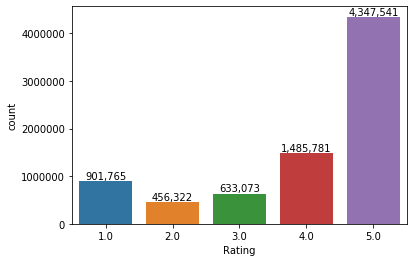

It is seen that most ratings are 4 or 5, so most customers seem happy with most of the products
This is assuming that rating 1 means least happy (or very unhappy) while 5 means very happy


In [13]:
temp=sns.countplot(df['Rating']); #semicolon suppresses unnecessary text like matplotlib.axes._subplots.... appearing
ax = plt.gca()
for p in ax.patches:
    temp=ax.text(p.get_x() + p.get_width()/2., p.get_height(),'{:,}'.format(p.get_height()),
                 fontsize=10,  ha='center', va='bottom')
plt.show()
print('It is seen that most ratings are 4 or 5, so most customers seem happy with most of the products')
print('This is assuming that rating 1 means least happy (or very unhappy) while 5 means very happy')

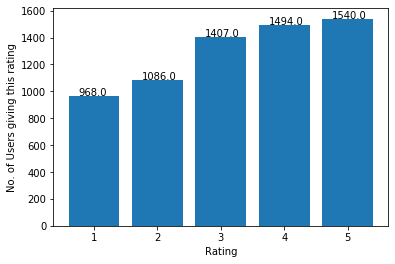

In [14]:
# Ploting number of users v/s Rating  
temp=pd.DataFrame(columns=['Rating','nofUsers'])
for R in new_data['Rating'].unique():
    temp.loc[len(temp)]= [R, len(new_data[new_data['Rating']==R]['userId'].unique())]
temp=temp.sort_values(by=['Rating']).reset_index(drop=True);
temp2=plt.bar(temp['Rating'], height= temp['nofUsers']);
temp2=plt.xlabel('Rating');
temp2=plt.ylabel('No. of Users giving this rating');
xlocs, xlabs = plt.xticks();
xlocs=[i+1 for i in range(0,len(temp['Rating']))];
xlabs=[i+1 for i in range(0,len(temp['Rating']))];
for i, v in enumerate(temp['nofUsers']):
    temp2=plt.text(xlocs[i] - 0.25, v +1, str(v));
temp2=plt.xticks(xlocs, xlabs);
plt.show()    
#in above code, assignment to temp2 done to suppress unnecesary text messages in output

In [15]:
print('Every user (among the unique 1540) is seen to have given at least 1 "5" rating, implying that')
print('all users are extremely happy at least with some products')
print('968 of 1540 users have given "1" rating, implying around 2/3 of the users are distinctly unhappy about some products')

Every user (among the unique 1540) is seen to have given at least 1 "5" rating, implying that
all users are extremely happy at least with some products
968 of 1540 users have given "1" rating, implying around 2/3 of the users are distinctly unhappy about some products


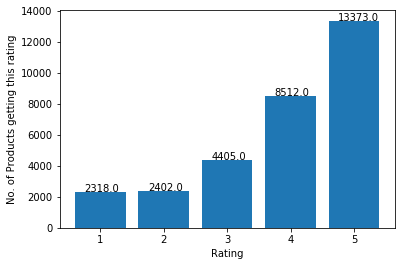

Only 13373 from among 16993 products have been given at least 1 "5" rating
That implies over 3600 products have not been rated "5"
At least 2318 users are very unhappy with some products, having rated them "1"


In [16]:
temp=pd.DataFrame(columns=['Rating','nofProducts'])
for R in new_data.Rating.unique():
    temp.loc[len(temp)]= [R, pd.DataFrame(new_data[new_data['Rating']==R].productId.unique()).shape[0]]
temp=temp.sort_values(by=['Rating']).reset_index(drop=True)
temp2=plt.bar(temp['Rating'], height= temp['nofProducts'])
temp2=plt.xlabel('Rating')
temp2=plt.ylabel('No. of Products getting this rating')
xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(0,len(temp['Rating']))]
xlabs=[i+1 for i in range(0,len(temp['Rating']))]
for i, v in enumerate(temp['nofProducts']):
    temp2=plt.text(xlocs[i] - 0.25, v +1, str(v))
temp2=plt.xticks(xlocs, xlabs)
plt.show()  

print('Only 13373 from among 16993 products have been given at least 1 "5" rating')
print('That implies over 3600 products have not been rated "5"')
print('At least 2318 users are very unhappy with some products, having rated them "1"')

Question 3. Split the data randomly into train and test dataset. ( For  example, split it in 70/30 ratio) 

In [17]:
#now we will divide the data in Train and Test sets

In [18]:
from sklearn.model_selection import train_test_split
print('A larger sample is expected to give better results for popularity, so entire dataset should be taken.')
print('However, since it is specifically asked for in the assignment instructions,')
print(' we are taking a train-test split using sklearn, and but using the original (>50users, >50product ratings) dataset')
print('for the popularity Recommender ')
print('for collaborative recommendation model we will split the data again later,')
print(' that time using surprise library and not sklearn.')
print('shape of the original dataset',new_data.shape[0],' rows and ', new_data.shape[1], 'columns')
print('Taking a training-data slice of 70% of the dataset')
train_pop, test_pop = train_test_split(new_data, test_size = 0.30, random_state=0)
print('shape of the training data is',train_pop.shape[0],' rows and ', train_pop.shape[1], 'columns')
print('')

A larger sample is expected to give better results for popularity, so entire dataset should be taken.
However, since it is specifically asked for in the assignment instructions,
 we are taking a train-test split using sklearn, and but using the original (>50users, >50product ratings) dataset
for the popularity Recommender 
for collaborative recommendation model we will split the data again later,
 that time using surprise library and not sklearn.
shape of the original dataset 79182  rows and  3 columns
Taking a training-data slice of 70% of the dataset
shape of the training data is 55427  rows and  3 columns



4. Build Popularity Recommender model

In [19]:
#Popularity Recommender Model(Non-personalized)(For Train Data)
ratings_mean_count = pd.DataFrame(train_pop.groupby('productId')['Rating'].mean()) 
print('mean of the ratings:\n',ratings_mean_count.head())

mean of the ratings:
             Rating
productId         
0972683275     4.5
1400501466     3.0
1400501520     5.0
1400501776     4.0
1400532620     1.0


In [20]:
#average ratings and Rating count per product
ratings_mean_count['rating_counts'] = pd.DataFrame(train_pop.groupby('productId')['Rating'].count().sort_values(ascending=False)) 
print('The Top 5 products sorted by mean ratings as well as the count of ratings are:')
popularity_recommendations=ratings_mean_count.sort_values(by= 'rating_counts',ascending=False).head(5) 
print(popularity_recommendations)
print('\nthe last 5 products(worst recommedations) are:\n',ratings_mean_count.sort_values(by= 'rating_counts',ascending=False).tail(5))


The Top 5 products sorted by mean ratings as well as the count of ratings are:
              Rating  rating_counts
productId                          
B0088CJT4U  4.207407            135
B003ES5ZUU  4.859375            128
B007WTAJTO  4.691057            123
B000N99BBC  4.811475            122
B00829TIEK  4.470588            102

the last 5 products(worst recommedations) are:
             Rating  rating_counts
productId                        
B001BPMLRS     3.0              1
B0056TO3P8     2.0              1
B0056QFARQ     5.0              1
B0056QBXKY     2.0              1
B003DKL56W     5.0              1


#Hence according to the rating count and the highest Ratings we can recommend the products as listed to the Users(Non-personalized) who is a new user and his data or previous preference is unknown to us

As we see above only Average rating is not a good parameter for popularity, as products with only 1 user rating them 5 will then appear at the top.eg. see productId B003DKL56W will then top the recommendation list with one user rating it "5"

Count of ratings combined with mean ratings is better, as product rated by many people with the mean top ratings, will be recommended to the end user/new user.

In [21]:
#Use popularity based recommender model to make predictions and find recommendations for random list of users
#with inferences

In [22]:
# Use popularity based recommender model to make predictions
def recommend(userId):     
    user_recommendations = popularity_recommendations 
          
    #Add userId column for which the recommendations are being generated 
    user_recommendations['userID'] = userId 
      
    #Bring userId column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [23]:
find_recom = ['adsfd','A2W0XCWOK3MW6F']   # This list is user choice.
for i in find_recom:
    print("Here is the top 5 recommendation for the userId: %s\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the top 5 recommendation for the userId: adsfd

           userID    Rating  rating_counts
productId                                 
B0088CJT4U  adsfd  4.207407            135
B003ES5ZUU  adsfd  4.859375            128
B007WTAJTO  adsfd  4.691057            123
B000N99BBC  adsfd  4.811475            122
B00829TIEK  adsfd  4.470588            102


Here is the top 5 recommendation for the userId: A2W0XCWOK3MW6F

                    userID    Rating  rating_counts
productId                                          
B0088CJT4U  A2W0XCWOK3MW6F  4.207407            135
B003ES5ZUU  A2W0XCWOK3MW6F  4.859375            128
B007WTAJTO  A2W0XCWOK3MW6F  4.691057            123
B000N99BBC  A2W0XCWOK3MW6F  4.811475            122
B00829TIEK  A2W0XCWOK3MW6F  4.470588            102




In [24]:
#As we can see above,even if we have new user (adsfd)the products recommended will be the same.
#in popularity based model(Non-personalized),the product recommended will be same for all the users as the recommendations 
#are based on the ranking of the products which the other users have given. We assume that there is no informaton about 
# the new user.

In [25]:
#As there is no predicted data(the recommendation is same for all users and there is no previous data) in the popularity 
#based Recommendation,RMSE cannot be calculated for the model.Hence now calculating the Recommendation using the full data 

In [26]:
ratings_mean_count1 = pd.DataFrame(new_data.groupby('productId')['Rating'].mean())
ratings_mean_count1['rating_counts'] = pd.DataFrame(new_data.groupby('productId')['Rating'].count().sort_values(ascending=False)) 
print('The Top 5 products(from full data) sorted by mean ratings as well as the count of ratings are:')
popularity_recommendations_full=ratings_mean_count1.sort_values(by= 'rating_counts',ascending=False).head(5) 
popularity_recommendations_full

The Top 5 products(from full data) sorted by mean ratings as well as the count of ratings are:


,Rating,rating_counts
productId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


In [27]:
# Use popularity based recommender model to make predictions
def recommend(userId):     
    user_recommendations_full = popularity_recommendations_full
          
    #Add userId column for which the recommendations are being generated 
    user_recommendations_full['userID'] = userId 
      
    #Bring userId column to the front 
    cols = user_recommendations_full.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations_full = user_recommendations_full[cols] 
          
    return user_recommendations_full
find_recom = ['A105S56ODHGJEK','ertyer']   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: A105S56ODHGJEK

                    userID    Rating  rating_counts
productId                                          
B0088CJT4U  A105S56ODHGJEK  4.218447            206
B003ES5ZUU  A105S56ODHGJEK  4.864130            184
B000N99BBC  A105S56ODHGJEK  4.772455            167
B007WTAJTO  A105S56ODHGJEK  4.701220            164
B00829TIEK  A105S56ODHGJEK  4.436242            149


Here is the recommendation for the userId: ertyer

            userID    Rating  rating_counts
productId                                  
B0088CJT4U  ertyer  4.218447            206
B003ES5ZUU  ertyer  4.864130            184
B000N99BBC  ertyer  4.772455            167
B007WTAJTO  ertyer  4.701220            164
B00829TIEK  ertyer  4.436242            149




In [28]:
def recommendation_full(userId):
    #temp= userIds.contains('userId')
    temp= userId in userIds
    if temp:
        print(userId, 'is userId from within our dataset. Background ratings available. Hence running collaborative')
        return (recommend_collaborative(userId))
    else:
        print(userId, 'is userId, not from within our dataset. Background ratings not available. Hence running popularity')
        return(recommend_popularity(userId))

In [29]:
# As we see for every user the products recommended are the same as the most popular products are recommended to every user
#as we do not have any previous history of the new user

Question 5. Build Collaborative Filtering model.

In [30]:
#Colaborative based modeling:
#Collaborative based modeling is where we recommend the user based on his previous likes and matching his profile 
#to the nearest possible neighbour.For each user, recommender systems recommend items based on how similar users 
#liked the item

In [31]:
# to split the data for colaborative recommendation we use surprise library. For the same we need to convert the dataframe into
#dataset
from surprise import Dataset
from surprise import Reader
import os
reader=Reader(rating_scale=(1,5))
data_df=Dataset.load_from_df(new_data,reader)

In [32]:
#splitting the data
from surprise.model_selection import train_test_split
train_data, test_data = train_test_split(data_df, test_size = 0.30, random_state=10)

In [33]:
print('Using SVD Technique for colaborative recommendation')
#Generate matrix table from ratings table
ratings_matrix = new_data.pivot(index='userId', columns='productId', values='Rating')
userIds = ratings_matrix.index
productIds = ratings_matrix.columns
print('actual ratings given by users: (', len(userIds), ' users and ', len(productIds), ' products) :')
print(' only 5 users and 5 products shown')
print('blank cell denotes that the particular user has not rated the particular product')
print(ratings_matrix.head().transpose().head().transpose().fillna(''))
ratings_matrix = ratings_matrix.fillna(0) # substituting by 0missing rating values, where a user has not rated a product
print('blank, rating for product not rated by user substituted by 0:')
print(ratings_matrix.head().transpose().head().transpose())

Using SVD Technique for colaborative recommendation
actual ratings given by users: ( 1540  users and  16993  products) :
 only 5 users and 5 products shown
blank cell denotes that the particular user has not rated the particular product
productId      0972683275 1400501466 1400501520 1400501776 1400532620
userId                                                               
A100UD67AHFODS                                                       
A100WO06OQR8BQ                                                       
A105S56ODHGJEK                                                       
A105TOJ6LTVMBG                                                       
A10AFVU66A79Y1                                                       
blank, rating for product not rated by user substituted by 0:
productId       0972683275  1400501466  1400501520  1400501776  1400532620
userId                                                                    
A100UD67AHFODS         0.0         0.0         0.0         0.

In [34]:
print('Generating predicted ratings using SVD with no.of singular values to be 5 ')
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(ratings_matrix, k = 5)#we have taken k=5 as asked in question
sigma = np.diag(sigma)

Generating predicted ratings using SVD with no.of singular values to be 5 


In [35]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = productIds, index = userIds)
print('predicted rating for every user for every product : only 5 usrs and 5 products shown')
print(preds_df.head().transpose().head().transpose())

predicted rating for every user for every product : only 5 usrs and 5 products shown
productId       0972683275  1400501466  1400501520  1400501776  1400532620
userId                                                                    
A100UD67AHFODS    0.008453    0.004318    0.003574    0.005948    0.001100
A100WO06OQR8BQ    0.019501    0.010495    0.001987    0.011328    0.001962
A105S56ODHGJEK    0.015824    0.004799   -0.002739    0.002894    0.002814
A105TOJ6LTVMBG    0.008789    0.005065    0.003048    0.005534    0.000355
A10AFVU66A79Y1    0.012662    0.006442    0.000477    0.006621    0.002263


In [36]:
preds_df.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.008453,0.004318,0.003574,0.005948,0.001100,0.019011,0.003159,0.001404,0.004533,0.003146,...,0.000181,0.378185,0.021078,0.034395,-0.000482,0.023355,-0.012058,0.042704,0.000788,0.339330
A100WO06OQR8BQ,0.019501,0.010495,0.001987,0.011328,0.001962,0.009685,0.001776,0.012840,0.007183,0.000720,...,0.000096,0.014248,0.001188,0.025355,0.024019,0.213184,0.074732,0.001612,0.006718,0.107158
A105S56ODHGJEK,0.015824,0.004799,-0.002739,0.002894,0.002814,-0.007147,-0.002106,0.009519,-0.001773,-0.001936,...,0.000056,-0.014008,0.004982,0.008421,0.017286,0.236835,0.063291,-0.002253,0.004639,0.052264
A105TOJ6LTVMBG,0.008789,0.005065,0.003048,0.005534,0.000355,0.010863,0.002608,0.002784,0.006157,0.001582,...,0.000021,0.013338,-0.004115,0.010412,0.007275,-0.000938,0.012347,-0.001666,0.001269,0.037627
A10AFVU66A79Y1,0.012662,0.006442,0.000477,0.006621,0.002263,0.003945,0.000567,0.008122,0.001288,-0.000040,...,-0.000004,-0.020595,-0.003040,0.004489,0.013781,0.117128,0.026898,-0.003742,0.003224,0.040441


In [37]:
# Take a particular userId
#a. Lets find the recommendations for user with id index 3
#b. Get the predicted ratings for userID and sort them in descending order

In [38]:
all_user_predicted_ratings

array([[ 8.45269188e-03,  4.31773600e-03,  3.57358683e-03, ...,
         4.27043976e-02,  7.88281870e-04,  3.39329763e-01],
       [ 1.95007872e-02,  1.04954068e-02,  1.98712770e-03, ...,
         1.61247240e-03,  6.71768589e-03,  1.07158150e-01],
       [ 1.58235018e-02,  4.79890987e-03, -2.73899297e-03, ...,
        -2.25289309e-03,  4.63919774e-03,  5.22642855e-02],
       ...,
       [ 7.27090070e-03,  9.21845528e-04,  5.66377552e-03, ...,
         1.28152991e-01, -6.67239779e-04,  9.08538225e-01],
       [ 4.33020698e-03,  2.47263659e-03,  8.54847781e-04, ...,
         4.85953477e-03,  2.24640829e-03,  5.18730469e-02],
       [ 9.06292605e-03,  4.04851159e-03,  1.83761656e-03, ...,
        -2.54571812e-03,  4.83348644e-04,  3.21201743e-02]])

7. Get top - K ( K = 5) recommendations. Since our goal is to  recommend new products for each user based on 
/her  habits, we will recommend 5 new products

In [39]:
# Recommend the items with the highest predicted ratings

def recommend_items(user_id, rating_matrix, preds_df, num_recommendations):
      
    #user_idx = userId-1 # index starts at 0
    userID = ratings_matrix.iloc[user_id-1, :].name
    # Get and sort the user's ratings
    sorted_user_ratings = rating_matrix.iloc[user_id].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_id].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for above user(userID = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [40]:
#Enter 'userID' and 'num_recommendations' for the user #
user_id = 3
num_recommendations = 5
recommend_items(user_id, ratings_matrix, preds_df, num_recommendations)


Below are the recommended items for above user(userID = A105S56ODHGJEK):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.797901
B003ES5ZUU                  0.0          0.774356
B002V88HFE                  0.0          0.441262
B001TH7GUU                  0.0          0.418235
B002WE6D44                  0.0          0.363809


In [41]:
# As above we get the top 5 recommendations for the particular userId.We can also find the recommendations for other user Id's
#If a new user Id comes up and if any of the customer has not given the ratings then the predictions for that
#user cannot be made and hence we will recommend the popularity based products(as shown in the popularity based recommendation)

Question 6. Evaluate both the models. ( Once the model is trained on  the training data, it can be used to compute the error  (RMSE) on predictions made on the test data.) 

Evaluation of Model-based Collaborative Filtering (SVD)

In [42]:
# Actual ratings given by the users
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Average ACTUAL rating for each item
ratings_matrix.mean().head()

productId
0972683275    0.012338
1400501466    0.012987
1400501520    0.003247
1400501776    0.005844
1400532620    0.003896
dtype: float64

In [44]:
# Predicted ratings 
preds_df.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.008453,0.004318,0.003574,0.005948,0.001100,0.019011,0.003159,0.001404,0.004533,0.003146,...,0.000181,0.378185,0.021078,0.034395,-0.000482,0.023355,-0.012058,0.042704,0.000788,0.339330
A100WO06OQR8BQ,0.019501,0.010495,0.001987,0.011328,0.001962,0.009685,0.001776,0.012840,0.007183,0.000720,...,0.000096,0.014248,0.001188,0.025355,0.024019,0.213184,0.074732,0.001612,0.006718,0.107158
A105S56ODHGJEK,0.015824,0.004799,-0.002739,0.002894,0.002814,-0.007147,-0.002106,0.009519,-0.001773,-0.001936,...,0.000056,-0.014008,0.004982,0.008421,0.017286,0.236835,0.063291,-0.002253,0.004639,0.052264
A105TOJ6LTVMBG,0.008789,0.005065,0.003048,0.005534,0.000355,0.010863,0.002608,0.002784,0.006157,0.001582,...,0.000021,0.013338,-0.004115,0.010412,0.007275,-0.000938,0.012347,-0.001666,0.001269,0.037627
A10AFVU66A79Y1,0.012662,0.006442,0.000477,0.006621,0.002263,0.003945,0.000567,0.008122,0.001288,-0.000040,...,-0.000004,-0.020595,-0.003040,0.004489,0.013781,0.117128,0.026898,-0.003742,0.003224,0.040441


In [45]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
0972683275    0.010873
1400501466    0.004726
1400501520    0.001463
1400501776    0.004496
1400532620    0.000863
dtype: float64

In [46]:
rmse_df = pd.concat([ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(16993, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0972683275,0.012338,0.010873,0
1400501466,0.012987,0.004726,1
1400501520,0.003247,0.001463,2
1400501776,0.005844,0.004496,3
1400532620,0.003896,0.000863,4


In [47]:
print('Evaluating model, based on RMSE as the metric')
print('RMSE = root of mean of squares of errors (predicted - actual), taken over the entire dataset')
print('the missing data (where a given user has not rated a particular product) should not be taken into account')
print('However, as we imputed such missing rating data as zero (0), we will consider both matrices fully')
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))
print('The error can vary from 0 to 5 (as the ratings can be 0 to 5)')
print('Thus the entire possible range for RMSE is 0 to 25')
print('An RMSE of ',RMSE, 'is thus very good')

Evaluating model, based on RMSE as the metric
RMSE = root of mean of squares of errors (predicted - actual), taken over the entire dataset
the missing data (where a given user has not rated a particular product) should not be taken into account
However, as we imputed such missing rating data as zero (0), we will consider both matrices fully

RMSE SVD Model = 0.00474 

The error can vary from 0 to 5 (as the ratings can be 0 to 5)
Thus the entire possible range for RMSE is 0 to 25
An RMSE of  0.00474 is thus very good


Using K Nearest Neighbour and user based colaborative filtering

In [48]:
#using K Nearest Neighbour and user based colaborative filtering


sim_options = {
    "name": "cosine",
    "user_based": True,  # Compute  similarities between items using cosine similsrity
}
algo = KNNWithMeans(k=5,sim_options=sim_options)

In [49]:
algo.fit(train_data)#Fitting the train data

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [50]:
# run the trained model against the testset
test_pred = algo.test(test_data)
test_pred

[Prediction(uid='AGVWTYW0ULXHT', iid='B00D96LZ6K', r_ui=4.0, est=3.9187707549482673, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A1VQHH85U7PX0', iid='B003CJTQJW', r_ui=5.0, est=4.901681945209318, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A3QUDXLOJTKEP9', iid='B00EZ9XGGC', r_ui=5.0, est=3.8642857142857143, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='ARBKYIVNYWK3C', iid='B00126T6HO', r_ui=4.0, est=4.296624388835766, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1PM7HH4F77NEH', iid='B001HKM1HM', r_ui=5.0, est=4.829677419354839, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A2L90SGUP36KGA', iid='B0007U0GZM', r_ui=2.0, est=4.285714285714286, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A5QDZEOIMQ4LW', iid='B0048L62I6', r_ui=5.0, est=4.815476190476191, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A1WUQF5H

In [51]:
#To inspect our predictions in details, we are going to build a pandas data frame with all the predictions. 
predictions = algo.fit(train_data).test(test_data)
df1 = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df1['err'] = abs(df1.est - df1.rui)
bestpredictions = df1.sort_values(by='err')[:5]
print('Best 5 Predictions:\n',bestpredictions) #.sort_values(by='err', ascending=False))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Best 5 Predictions:
                   uid         iid  rui  est  \
11967  A1X1CEGHTHMBL1  B0055QYJIS  5.0  5.0   
21655   A74UT8IQCM0I2  B00DKBU5W4  5.0  5.0   
16980   AEIB3UR05OP7A  B009SYZ8OC  5.0  5.0   
16989   AS2II0671KT2C  B0046TJG1U  5.0  5.0   
6879   A10O7THJ2O20AG  B008O6R5ZK  5.0  5.0   

                                        details  err  
11967  {'actual_k': 2, 'was_impossible': False}  0.0  
21655  {'actual_k': 1, 'was_impossible': False}  0.0  
16980  {'actual_k': 5, 'was_impossible': False}  0.0  
16989  {'actual_k': 3, 'was_impossible': False}  0.0  
6879   {'actual_k': 0, 'was_impossible': False}  0.0  


In [52]:
#From the table above and the output of test_pred we have predicted the product's estimated ratings(est) against the actual
#ratings(rui). uid is the userId and iid is the productId. actual k tells the actual number of neighbours found out of 5 
# which was specified in the algorithm.'was impossible' tell us if we found the neighbour or not. So if 'was impossible'=False
# atleast one neighbour was found. but if 'was impossible'=True, no neighbour is found and that particular userId lands
# in gray sheep area ie the customer

In [53]:
from collections import defaultdict
def get_top_n(test_pred, n=10):
    # First map the predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

top_n = get_top_n(test_pred, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])


AGVWTYW0ULXHT ['B002C744K6', 'B002O3KVSC', 'B00BOHNYU6', 'B0052N9HWM', 'B007K3SB6K']
A1VQHH85U7PX0 ['B000TXZIDM', 'B0002WPSBC', 'B001TOD7ME', 'B0000BZL28', 'B00007E7JU']
A3QUDXLOJTKEP9 ['B00EOD7JXA', 'B00BOHNYTW', 'B005LU2Z2A', 'B001H0GI9Y', 'B008HIZ0FW']
ARBKYIVNYWK3C ['B003WO7MZC', 'B00347L6I6', 'B000UXDHNY', 'B0012JHY7K', 'B001IAYUM0']
A1PM7HH4F77NEH ['B004JQQDZ2', 'B001HKM1HM', 'B0028N78HA', 'B005SAKW9G', 'B005IDTH76']
A2L90SGUP36KGA ['B000I1X3W8', 'B003WV5DJC', 'B0051XJXJU', 'B005BI5WMW', 'B0045TKC7S']
A5QDZEOIMQ4LW ['B0048L62I6', 'B003QKBVYK', 'B000KZALSG', 'B00009X3UA', 'B0078P6O8W']
A1WUQF5HWBAQJU ['B002WE6D44', 'B008MB71IS', 'B000MDZKUU', 'B00G4V0QSK', 'B0058G40O8']
A3QMJMTLJC34QC ['B001GAOYCS', 'B003HFCDLY', 'B0011U65F2', 'B0095ABFGO', 'B001SJVU24']
A1YEPFLLH42OU1 ['B006V72AHC', 'B0052SCU8U', 'B002YU83YO', 'B001BKS3Z2', 'B00BOHNYU6']
A5KMMY627T3W ['B000BY52NK', 'B000LGGAD4', 'B000AL8JKW', 'B0012W9APQ', 'B000DINCIQ']
A7FDGFK0KN7QG ['B004Y1AYAC', 'B002MUAEX4', 'B0042X9LC4', 'B0

AYCAIHABPYWVJ ['B004N6259G', 'B003NREDG4', 'B00006I53V', 'B003MSSW84', 'B001SEQN3U']
A2RU4U1JZ3DMP5 ['B001S2RCWI', 'B000ANRP82', 'B00017LSPI', 'B00483WRZ6', 'B0028R3NCU']
A1S7BFT0HDF3HA ['B000R9A9JG', 'B0038KN114', 'B005PC7VG4', 'B007P4VOWC', 'B005KP473Q']
A2V2URLB31HG59 ['B009UWK93M', 'B007SHJIO2', 'B0052D3750', 'B004T9RR6I', 'B003M8HWDA']
ATDQ9CGCWTT8D ['B00E3W15P0', 'B0034KO59U', 'B0046RE3M4', 'B0018QRO9A', 'B007HH95F0']
A35KBAQ4VBNQ6L ['B0051XDOZO', 'B0002L5R78', 'B007WTAJTO', 'B0002MQGK4', 'B000V0DY7U']
A2IFGGXG3YV3Y6 ['B003ZUXX4W', 'B004FLL5AY', 'B005BCCML2', 'B0035FZJHQ', 'B007JCNOHI']
A3R1GJY2MY8041 ['B003ZYF3M8', 'B0036AZA6A', 'B007A9NSR6', 'B0015L0T68', 'B003M2YT96']
AEL6CQNQXONBX ['B00BIFNTMC', 'B0082E9K7U', 'B00H4OWPE4', 'B002R5AM7C', 'B007PJ4P4G']
A1Z4GII5CHCDG7 ['B003L5D0OE', 'B0076W9Q5A', 'B00267S7XW', 'B003D8GAA0', 'B000FL9E6K']
A2F4HP0J5VNOYR ['B0043RS864', 'B00889ST2G', 'B000P3ZADE', 'B001GQ2W6W', 'B0019WX7KI']
A1WF4QNIE2Z3I7 ['B0099SMFVQ', 'B007R1FH3K', 'B005ES0YYA',

In [54]:
#As seen above we have got for all the users, the top 5 products they are recommended as per their liking.
# This Recommendation is made to maximise the revenue/sales for the website/organization

In [55]:
#We use “rmse” as our accuracy metric for the predictions.
print("User-based KNN Colaborative Recommendation Model : RMSE")
accuracy.rmse(test_pred, verbose=True)

User-based KNN Colaborative Recommendation Model : RMSE
RMSE: 1.0562


1.0562441433688974

In [56]:
# As seen above the RMSE for the KNN method is 1.056 which is higher than SVD(0.0047). Hence we will prefer the SVD method for
#recommending the users for the products

Question:8:  Summarise your insights

The observations are as follows:

 1.In popularity based model(Non-personalized),the product recommended will be same for all the users, as the recommendations 
 are based on the rating of the products which the other users have given. We assume that there is no information about 
 the new user.
 As we can see below,even if we have new user (ertyer,not in the data)the products recommended will be the same as with the other users.

Here is the recommendation for the userId: A105S56ODHGJEK

               userID   productId  score  Rank
13972  A105S56ODHGJEK  B0088CJT4U    206   1.0
8495   A105S56ODHGJEK  B003ES5ZUU    184   2.0
3285   A105S56ODHGJEK  B000N99BBC    167   3.0
13711  A105S56ODHGJEK  B007WTAJTO    164   4.0
13841  A105S56ODHGJEK  B00829TIEK    149   5.0


Here is the recommendation for the userId: ertyer

       userID   productId  score  Rank
13972  ertyer  B0088CJT4U    206   1.0
8495   ertyer  B003ES5ZUU    184   2.0
3285   ertyer  B000N99BBC    167   3.0
13711  ertyer  B007WTAJTO    164   4.0
13841  ertyer  B00829TIEK    149   5.0
 
 2.As there is no predicted data(the recommendation is same for all users and there is no previous data available for the new user) in the popularity based Recommendation model,RMSE cannot be calculated for the model.Hence first we have calculated with the training data and then we have calculated the popularity matrix by full data(above output is for the full data)

3.We could find the top 5 products which can be recommended by the Singular Vector Decomposition(SVD) method in Collaborative 
Recommendation Methods
For example the best products recommended to A105S56ODHGJEK user id is as below 
Below are the recommended items for above user(userID = A105S56ODHGJEK):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.725106
B003ES5ZUU                  0.0          0.715791
B002V88HFE                  0.0          0.417883
B001TH7GUU                  0.0          0.382170
B000QUUFRW                  0.0          0.337131

Collaborative Filtering based model has recommended entire different list based on the user past purchase history and the preference/liking of the customer while the Popularity based model has recommended the same set of 5 products to both users.

4. Hence we see that Model based Collaborative Filtering is better than the Popularity based model for personalized feel to the customer. While Popularity based Recommendation model is Non personalized and good for the new customer (of which we have no previous data). Also it helps from preventing the cold start problem for any company/website/organization to market their product.

5. Hence we can say that both the models have their own pros and cons but in long run, Model based Collaborative Filtering is better than the Popularity based model as Collaborative Filtering Recommendation model has more personalized recomendation for the users.

6.When we compared the models SVD and KNN ,the best method was found to be SVD with less error(rmse=.0047)

7.To split the data for colaborative recommendation (KNN)we use surprise library.

8.Recommendation is the best way to sell any product or services be it online or offline. Today marketiers want the sales to
increase by recommending the products the customer would like the most, thus by increasing the sales and bottom line for the companies.

7.In this example where the products are electronic products (the types or make not given),a particular user like in our example user id A105S56ODHGJEK can be recommended the products as shown. These products would be related to each other
for example :can be Televisions of different brands bundled with an amazon fire TV stick or Mobiles of different brands coupled with mobile cover and screen gaurd. 
So instead of selling the customer just one item we have sold 2-3 items at one time only, which is profitable to both customer and more to the companies.

8. Customer recommendations lead to more customer satisfaction and more repeat visits to the website.When the recommendations are personalized for each customer, the customer seem to enjoy the look and feel of the place/website leading to more visits hence cashing them into more sales and a feel good factor for the customer also. Hence in long run we preffer Collaborative Filtering Recommendation model.

9. To summarize, Recommendation Systems are internal part of our lives online and offline and we can harness the same for 
our profits as shown above.